In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Libraries and Filesystem Setup

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /Users/dkarsann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dkarsann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### (already have imported / processed dataframe and stopwords)

## Parsing and Processing Content

In [3]:
df_en = pd.read_csv('../../processed_files/only_en.csv')
df_en.head()

,DOMAIN,RAW_CONTENT,LANGUAGE
0,x10-hk.com,automation@home » » | | quick find categories ...,en
1,hupshenghware.com,captcha powered by imunify360 english hupsheng...,en
2,soponyonosnack.com,soponyonosnack.com currencies: rupiah language...,en
3,theromanticvineyard.com,wine train (blogroll) | the romantic vineyard ...,en
4,eopticians.co.uk,"brands, base curve (bc): 8.4, base curve (bc):...",en


### load stopword lists from MastersProjectStopwords.ipynb

In [4]:
common_stopwords = pickle.load(open("../../processed_files/common_stopwords.pickle", "rb"))
corpus_stopwords = pickle.load(open("../../processed_files/corpus_stopwords.pickle", "rb"))
combined_stopwords = pickle.load(open("../../processed_files/combined_stopwords.pickle", "rb"))
corpus_bigrams = pickle.load(open("../../processed_files/corpus_bigrams.pickle", "rb"))
corpus_trigrams = pickle.load(open("../../processed_files/corpus_trigrams.pickle", "rb"))

In [5]:
#corpus_bigrams

In [6]:
#corpus_trigrams

## Merging duplicate domain

In [5]:
df_merged = pd.DataFrame(df_en.groupby('DOMAIN')['RAW_CONTENT'].agg('sum')).reset_index()
df_merged.head()

,DOMAIN,RAW_CONTENT
0,0-my.com,0-my.com related searches: related searches:
1,00bitz.com,error. page cannot be displayed. please contac...
2,01187.com,01187.com is available for purchase! - wwwv1.c...
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons..."
4,03h.org,february | 2014 | online marketing review sear...


In [6]:
number_domain = df_merged['DOMAIN'].nunique()
number_domain

12975

In [7]:
df_merged.shape

(12975, 2)

In [8]:
with open('../../processed_files/df_merged.pickle', 'wb') as file:
    pickle.dump(df_merged, file)

## TEXT Processing

In [9]:
doc_length_list_orig = []
doc_length_list_no_digits = []
doc_length_list_no_tri = []
doc_length_list_no_bi = []
doc_length_list_tokenized = []
doc_length_list_no_stop = []
doc_length_list_stemmed = []

In [12]:
#digits

In [13]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from string import digits
remove_digits = str.maketrans('', '', digits)
from IPython.display import display

def process(content):
    
    #--------original--------#
    doc_length_list_orig.append(len(content))
    
    #--------no digits--------#
    processed = content.translate(remove_digits)
    doc_length_list_no_digits.append(len(processed))
    
    #--------lower case--------#
    processed = processed.lower()
    
    # remove punctuation with translation table before trigram step
    
    #--------remove trigrams--------#
    for trigram in corpus_trigrams:
        processed = processed.replace(trigram.lower(), '')
    doc_length_list_no_tri.append(len(processed))

    #--------remove bigrams--------#
    for bigram in corpus_bigrams:
        processed = processed.replace(bigram.lower(), '') 
    doc_length_list_no_bi.append(len(processed))
    
    #--------tokenize--------#
    processed = tokenizer.tokenize(processed)
    doc_length_list_tokenized.append(len(' '.join(processed)))
    
    #--------remove stopwords--------#
    processed = [token for token in processed if token not in stop_words]
    doc_length_list_no_stop.append(len(' '.join(processed)))
    
    #--------stem tokens--------#
    processed = [ps.stem(token) for token in processed]
    doc_length_list_stemmed.append(len(' '.join(processed)))
    
    return processed

In [14]:
df_merged['RAW_CONTENT_PROCESSED'] = df_merged['RAW_CONTENT'].apply(lambda row: process(row))
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED
0,0-my.com,0-my.com related searches: related searches:,"[com, relat, search, relat, search]"
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, display, pleas, contact,..."
2,01187.com,01187.com is available for purchase! - wwwv1.c...,"[com, vailabl, purchas, wwwv, com, welcom, uun..."
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...","[ir, dn, ir, ir, hit, construct, come, soon, h..."
4,03h.org,february | 2014 | online marketing review sear...,"[februari, onlin, market, review, search, rece..."


In [15]:
df_merged['length'] = df_merged['RAW_CONTENT_PROCESSED'].apply(lambda row: len(row))
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,length
0,0-my.com,0-my.com related searches: related searches:,"[com, relat, search, relat, search]",5
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, display, pleas, contact,...",9
2,01187.com,01187.com is available for purchase! - wwwv1.c...,"[com, vailabl, purchas, wwwv, com, welcom, uun...",140
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...","[ir, dn, ir, ir, hit, construct, come, soon, h...",25
4,03h.org,february | 2014 | online marketing review sear...,"[februari, onlin, market, review, search, rece...",172


In [16]:
print('doc_length_list_orig: ', sum(doc_length_list_orig) / len(doc_length_list_orig))
print('doc_length_list_no_digits: ', sum(doc_length_list_no_digits) / len(doc_length_list_no_digits))
print('doc_length_list_no_tri average: ', sum(doc_length_list_no_tri) / len(doc_length_list_no_tri))
print('doc_length_list_no_bi: ', sum(doc_length_list_no_bi) / len(doc_length_list_no_bi))
print('doc_length_list_tokenized: ', sum(doc_length_list_tokenized) / len(doc_length_list_tokenized))
print('doc_length_list_no_stop: ', sum(doc_length_list_no_stop) / len(doc_length_list_no_stop))
print('doc_length_list_stemmed: ', sum(doc_length_list_stemmed) / len(doc_length_list_stemmed))

doc_length_list_orig:  5280.747437379576
doc_length_list_no_digits:  5152.000924855492
doc_length_list_no_tri average:  5087.480616570328
doc_length_list_no_bi:  4906.422504816956
doc_length_list_tokenized:  4659.20816955684
doc_length_list_no_stop:  3614.5058188824664
doc_length_list_stemmed:  3197.338342967245


In [17]:
doc_length_list_stemmed.sort()
doc_length_list_stemmed_filtered = [item for item in doc_length_list_stemmed if item > 0 and item < 200]
least_to_most_filtered_plot_items = []
for item in enumerate(doc_length_list_stemmed):
    least_to_most_filtered_plot_items.append(item)

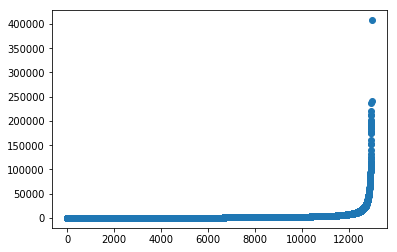

In [18]:
x, y = zip(*least_to_most_filtered_plot_items)
plt.scatter(x, y)
plt.show()

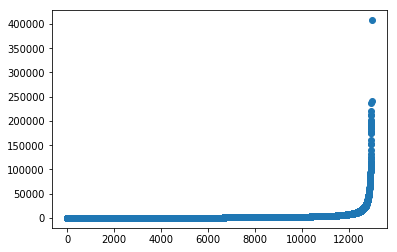

In [19]:
x, y = zip(*least_to_most_filtered_plot_items)
plt.scatter(x, y)
plt.show()

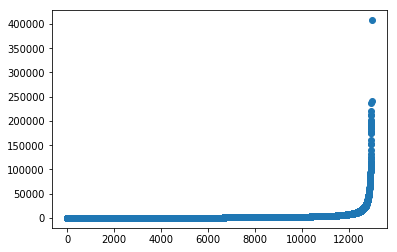

In [20]:
x, y = zip(*least_to_most_filtered_plot_items)
plt.scatter(x, y)
plt.show()

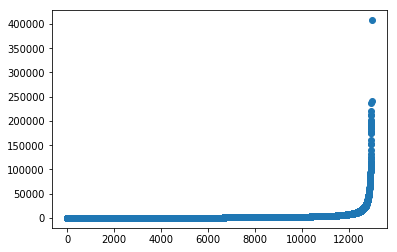

In [21]:
x, y = zip(*least_to_most_filtered_plot_items)
plt.scatter(x, y)
plt.show()

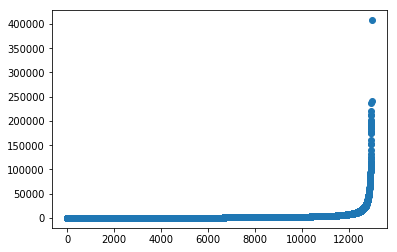

In [22]:
x, y = zip(*least_to_most_filtered_plot_items)
plt.scatter(x, y)
plt.show()

In [23]:
df_merged[df_merged['length'].between(90, 95)].style.set_properties(subset=['RAW_CONTENT'], **{'width-min': '100px'})

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,length
16,12thcambridge.org.uk,"the committee - 12th cambridge scout group12th cambridge scout group do more. share more. be more. the committee the group is led by colin sills, the group scout leader (gsl), supported by the executive committee. group executive committee 2017-18 chairman – seb barker secretary – alison vinnicombe treasurer – john cornish members – natasha werdmuller, karrie fuller, stephen longden, naomi griffiths, dave potts, sam wright and phil garrett just like the rest of the leaders they are all volunteers who undergo a dbs check and give valuable support to the section leaders by keeping the hq repaired, raising funds, keeping accounts and generally keeping the road under the show. if you would like to volunteer to be part of the committee please let us know and we would be happy to co-opt you and find you a job! 12th cambridge scout group. charity number 300711","['committe', 'th', 'cambridg', 'scout', 'groupth', 'cambridg', 'scout', 'group', 'share', 'committe', 'group', 'led', 'colin', 'sill', 'group', 'scout', 'leader', 'gsl', 'support', 'execut', 'committe', 'group', 'execut', 'committe', 'chairman', 'seb', 'barker', 'secretari', 'alison', 'vinnicomb', 'treasur', 'john', 'cornish', 'member', 'natasha', 'werdmul', 'karri', 'fuller', 'stephen', 'longden', 'naomi', 'griffith', 'dave', 'pott', 'sam', 'wright', 'phil', 'garrett', 'like', 'rest', 'leader', 'volunt', 'undergo', 'db', 'check', 'give', 'valuabl', 'support', 'section', 'leader', 'keep', 'hq', 'repair', 'rais', 'fund', 'keep', 'account', 'gener', 'keep', 'road', 'show', 'would', 'like', 'volunt', 'part', 'committe', 'pleas', 'let', 'us', 'know', 'would', 'happi', 'co', 'opt', 'find', 'job', 'th', 'cambridg', 'scout', 'group', 'chariti', 'number']",92
31,1860tour.com,"1860tour.com is for sale 1860tour.com is available for sale! 1860tour.com $280.00 privacy protection included order total $280.00 you won't be charged yet instant domain ownership dedicated customer care every order is 100% guaranteed there's only one 1860tour.com domain. once purchased, it may never become available again. 1860tour.com is owned and listed by a sav customer. | | copyright © 2020 sav.com, llc contact sav × have a question about an order you placed on this website or the business that previously used it? sav is a domain marketplace where people can buy and sell domain names that are no longer being used. if you have worked with a company/person that used this domain name in the past, it typically means that they no longer own this domain name and its being listed for sale by someone else. we would love to be able to help you reach them a different way but are not given any contact details for the previous owner. have a question about a domain you own or want to purchase? now those we can help with!","['tour', 'com', 'sale', 'tour', 'com', 'vailabl', 'sale', 'tour', 'com', 'privaci', 'protect', 'includ', 'order', 'total', 'charg', 'yet', 'instant', 'domain', 'ownership', 'dedic', 'custom', 'care', 'everi', 'order', 'guarante', 'one', 'tour', 'com', 'domain', 'purchas', 'may', 'never', 'becom', 'avail', 'tour', 'com', 'own', 'list', 'sav', 'custom', 'copyright', 'sav', 'com', 'llc', 'contact', 'sav', 'question', 'order', 'place', 'websit', 'busi', 'previous', 'use', 'sav', 'domain', 'marketplac', 'peopl', 'buy', 'sell', 'domain', 'name', 'longer', 'use', 'work', 'compani', 'person', 'use', 'domain', 'name', 'past', 'typic', 'mean', 'thi', 'longer', 'domain', 'name', 'list', 'sale', 'someon', 'els', 'would', 'love', 'help', 'reach', 'differ', 'way', 'given', 'contact', 'detail', 'previou', 'owner', 'question', 'domain', 'purchas', 'help']",95
180,a1laptop.ca,"a1 laptop repair toggle navigation store hours: monday-friday: 10am-6pm | saturday: 10am-1pm | sunday: closed a1 laptop repair cat, hdmi & many more cables available! plenty of laptops always changing! mice, keyboards & more! walls of cables & connections! welcome to a1 la

### 1 - doc_length_list_orig

In [24]:
doc_length_list_orig.sort()
least_to_most_plot_items = []
for item in enumerate(doc_length_list_orig):
    least_to_most_plot_items.append(item)

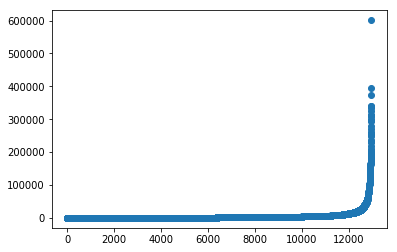

In [25]:
x, y = zip(*least_to_most_plot_items)
plt.scatter(x, y)
plt.show()

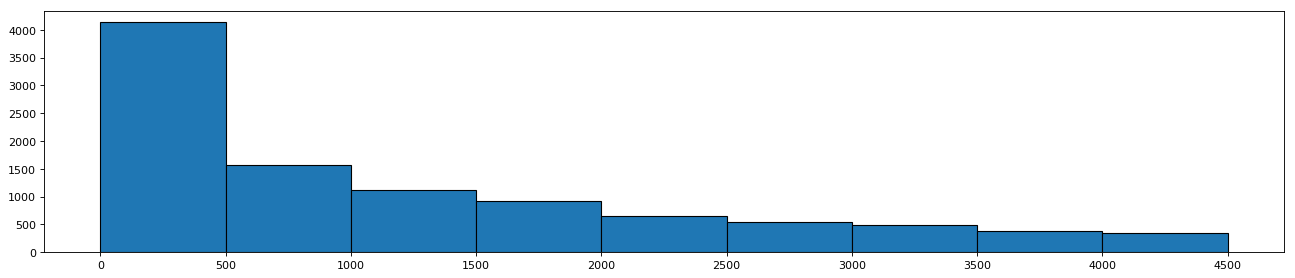

In [26]:
# bins = range(0, 10000, 1000)
bins = range(0, 5000, 500)
# bins = range(0, 1000, 100)
figure(figsize=(20, 4), dpi=80)
plt.hist(doc_length_list_orig, bins=bins, edgecolor="k")
plt.xticks(bins);

### 2 - doc_length_list_no_digits

In [67]:
#doc_length_list_no_digits.sort()
#least_to_most_plot_items = []
#for item in enumerate(doc_length_list_no_digits):
#    least_to_most_plot_items.append(item)

In [68]:
#x, y = zip(*least_to_most_plot_items)
#plt.scatter(x, y)
#plt.show()

In [66]:
# bins = range(0, 10000, 1000)
#bins = range(0, 5000, 500)
#figure(figsize=(20, 4), dpi=80)
#plt.hist(doc_length_list_no_digits, bins=bins, edgecolor="k")
#plt.xticks(bins);

### 3 - doc_length_list_no_tri

In [64]:
#doc_length_list_no_tri.sort()
#least_to_most_plot_items = []
#for item in enumerate(doc_length_list_no_tri):
#    least_to_most_plot_items.append(item)

In [65]:
#x, y = zip(*least_to_most_plot_items)
#plt.scatter(x, y)
#plt.show()

In [63]:
# bins = range(0, 10000, 1000)
#bins = range(0, 5000, 500)
#figure(figsize=(20, 4), dpi=80)
#plt.hist(doc_length_list_no_tri, bins=bins, edgecolor="k")
#plt.xticks(bins);

### 4 - doc_length_list_no_bi

In [62]:
#doc_length_list_no_bi.sort()
#least_to_most_plot_items = []
#for item in enumerate(doc_length_list_no_bi):
#    least_to_most_plot_items.append(item)

In [61]:
#x, y = zip(*least_to_most_plot_items)
#plt.scatter(x, y)
#plt.show()

In [60]:
# bins = range(0, 10000, 1000)
#bins = range(0, 5000, 500)
#figure(figsize=(20, 4), dpi=80)
#plt.hist(doc_length_list_no_bi, bins=bins, edgecolor="k")
#plt.xticks(bins);

### 5 - doc_length_list_tokenized

In [58]:
#doc_length_list_tokenized.sort()
#least_to_most_plot_items = []
#for item in enumerate(doc_length_list_tokenized):
#    least_to_most_plot_items.append(item)

In [59]:
#x, y = zip(*least_to_most_plot_items)
#plt.scatter(x, y)
#plt.show()

In [57]:
# bins = range(0, 10000, 1000)
#bins = range(0, 5000, 500)
#figure(figsize=(20, 4), dpi=80)
#plt.hist(doc_length_list_tokenized, bins=bins, edgecolor="k")
#plt.xticks(bins);

### 6 - doc_length_list_no_stop

In [56]:
#doc_length_list_tokenized.sort()
#least_to_most_plot_items = []
#for item in enumerate(doc_length_list_tokenized):
#    least_to_most_plot_items.append(item)

In [52]:
#x, y = zip(*least_to_most_plot_items)
#plt.scatter(x, y)
#plt.show()

In [55]:
# bins = range(0, 10000, 1000)
#bins = range(0, 5000, 500)
#figure(figsize=(20, 4), dpi=80)
#plt.hist(doc_length_list_tokenized, bins=bins, edgecolor="k")
#plt.xticks(bins);

### 7 - doc_length_list_stemmed

In [27]:
doc_length_list_stemmed.sort()
least_to_most_plot_items = []
for item in enumerate(doc_length_list_stemmed):
    least_to_most_plot_items.append(item)

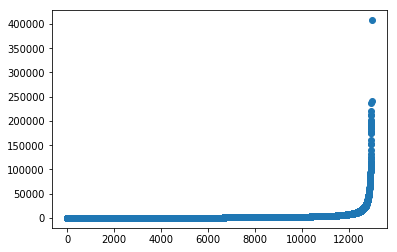

In [28]:
x, y = zip(*least_to_most_plot_items)
plt.scatter(x, y)
plt.show()

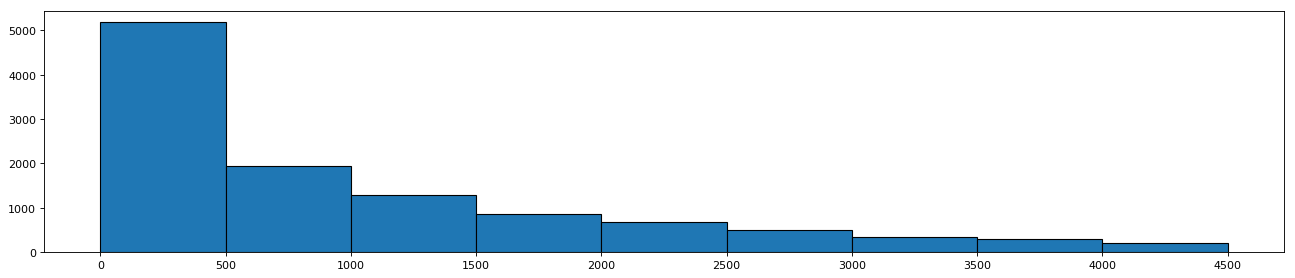

In [29]:
# bins = range(0, 10000, 1000)
bins = range(0, 5000, 500)
figure(figsize=(20, 4), dpi=80)
plt.hist(doc_length_list_stemmed, bins=bins, edgecolor="k")
plt.xticks(bins);